## Binary cipher

While ciphers in the past worked on letters, words and symbols, computers opened up new doors in cryptography by operating at a binary level. We're going to learn about a type of cipher that can be used to encrypt files at the binary level, and then see how an attacker could break it.

#### Discussion: where do you think you encounter encryption in your day-to-day life?

Once you're ready to move on, click [here](#skip_to_start) to skip the boring parts of loading a bunch of code, but you can read them if you're curious.

   #### Load some necessary add-ons

In [1]:
from PIL import Image #To create images
from IPython import display #To display images
import secrets #To get random bytes
import ipywidgets as widgets
import uuid #To get random file names

#### Create some functions of our own

In [2]:
#This function takes in a file and gives a bytes for it
def load_file_as_bytes(filename,max_len=-1):
    file_in = open(filename,'rb')
    byte_array = bytearray()
    byte_in = file_in.read(1)
    while byte_in != b"" and ((len(byte_array) < max_len) or (max_len == -1)):
        byte_array += byte_in
        byte_in = file_in.read(1)
        
    file_in.close()
    
    return byte_array
            
#This function creates a black-and-white picture of our bytes (black=0, white=1)
def draw_image_from_byte_array(b_array,filename="imgout.png",width=2048,height=2048):
    assert (width%8 == 0)
    
    if len(b_array) < (width * height//8):
        height = len(b_array)//(width//8)
    img = Image.new("1", (width,height))
    
    for row in range(height):
        for byte_index in range(width//8):  
            byte = b_array[row*(width//8) + byte_index]
            for bit_index in range(8):
                b = (byte >> (7-bit_index))%2               
                img.putpixel((byte_index*8 + bit_index,row),b)
                
    img.save(filename)

def present_binary(filename):
    width = width_slider.value
    height = height_slider.value
    b = load_file_as_bytes(filename,max_len=width*height)
    tmp_filename = str(uuid.uuid4())+".png"
    draw_image_from_byte_array(b,tmp_filename,width,height)
    return display.Image(tmp_filename,width=width*zoom_slider.value,height=height*zoom_slider.value)

<a id='skip_to_start'></a>
## Look at files in binary

We can visualise the binary data to give us a better understanding of the file structure. This can help in understanding what the file type is. The widgets below will let you see the start of several different file types. Changing the width and height sliders below might help you see more meaningful structures in the files. Each pixel is a bit, with black being 0, and white being 1.

In [3]:
file_dict = {
    "Image":"image.bmp",
    "Text":"alice.txt",
    "ZIP":"example.zip",
    "Program":"program.exe",
    "PDF":"puzzles.pdf",
    "Song":"song.wav"
}

def button_present(_arg):
    out.clear_output()
    out.append_display_data(present_binary(path_to_samples+file_dict[rdbuttons.value]))
    
width_slider = widgets.IntSlider(value=256,min=64,max=1024,step=8,description='Width')
height_slider = widgets.IntSlider(value=256,min=64,max=1024,description='Height')
zoom_slider = widgets.FloatSlider(value=1.0,min=0.5,max=4.0,description='Zoom factor')
path_to_samples = "Sample Files\\"
out = widgets.Output()

button = widgets.Button(description="Analyse!")
button.on_click(button_present)

rdbuttons = widgets.RadioButtons(
    options=file_dict.keys(),
    description='File type:'
)

widgets.VBox([width_slider,height_slider,zoom_slider,rdbuttons,button,out])

Each file type could be storing its data in different ways.

#### Discussion: What structures could you see? Did some widths make these more evident?

## Look at random

In some sense, the purpose of encryption is to make the encrypted data look as random as possible. We'll see later that any structure left in the encrypted data might be exploitable to find patterns that help us break the cipher.

Humans are pretty bad judges of random, often seeing meaning and structure where there isn't any. Thankfully, computers can be very good at being unbiased. Press the button below to generate a giant block of computer random.

In [9]:
def random_present(arg):
    with out2:
        out2.clear_output()
        random_bytes = secrets.token_bytes(512*512)
        draw_image_from_byte_array(random_bytes,filename="random.png",width=512,height=512)
        out2.append_display_data(display.Image("random.png"))


out2 = widgets.Output()
button2 = widgets.Button(description="Generate random!")
button2.on_click(random_present)

widgets.VBox([button2,out2])

#### Discussion: How does this compare to the files we saw earlier? Did one of the files look particularly random before?

#### Tricky discussion: Why might the file earlier have look 'random'?

With that settled, let's move on to a binary operation we'll use.

## Exclusive-Or (XOR)

XOR (Exclusive-or) (symbol ⊕) is an operation, like addition or subtraction. In fact, it's a lot like addition in binary, except we ignore any carries.

That is: 1 ⊕ 1 = 0, 1 ⊕ 0 = 1, and 0 ⊕ 0 = 0.

Another way to think about it is A ⊕ B = 1 if A and B are different bits, and A ⊕ B = 0 if A and B are the same bit.

If there are multiple units, like in the case of a byte, we can treat them all individually.

For example, 111 ⊕ 101 = 010.

#### Question: The opposite of addition is subtraction: if we start with a number, add X, and then subtract X, we are back to the starting number. What is the opposite of XOR?

## Learn XOR mask crypt

XOR is a fairly important building block of modern cryptography. It can be as simple as taking a block of secret random and XORing it with your message. If this is done with some caveats (like the secret block as long as the message, and never used again) then the system is proven to be 100% secure. 

Let's walk through this encryption to see what effect is has on the binary.

## Encrypt files

Let's get the computer to generate a secret key, then encrypt the text file.

Choose a key length for us to use. In this case, the longer the key the more secure it will be, and at some point the attack we use will stop working. Note that this is not always a reliable assumption!

In [24]:
global my_key

key_slider = widgets.IntSlider(value=16,min=1,max=1024,description='Key Length')

def encrypt(b,k):
    bytes_out = bytearray([])
    i = 0
    for byte in b:
        bytes_out.append(byte ^ k[i%len(k)])
        i += 1
    return bytes_out

keytext = widgets.Output(value="---", description = "Key:")
gen_button = widgets.Button(description="Generate key")

def generate_key(b):
    global my_key
    my_key = secrets.token_bytes(key_slider.value)
    with keytext:
        keytext.clear_output()
        print("Your key is:",''.join(["%02x"%x for x in my_key]))

gen_button.on_click(generate_key)
widgets.VBox([key_slider,gen_button,keytext])

## Look at files



The original binary file:


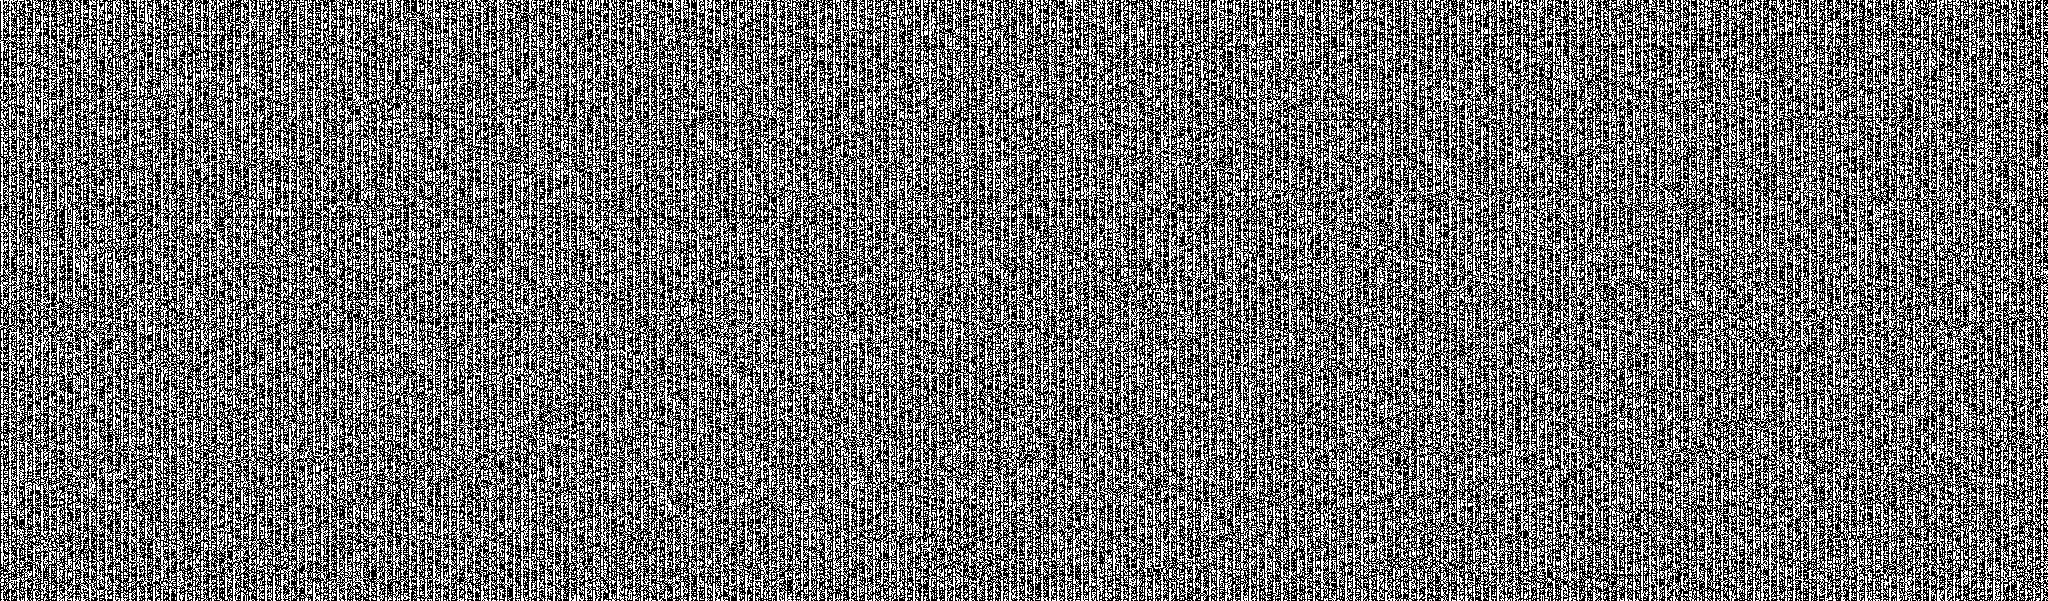

The encrypted binary file:


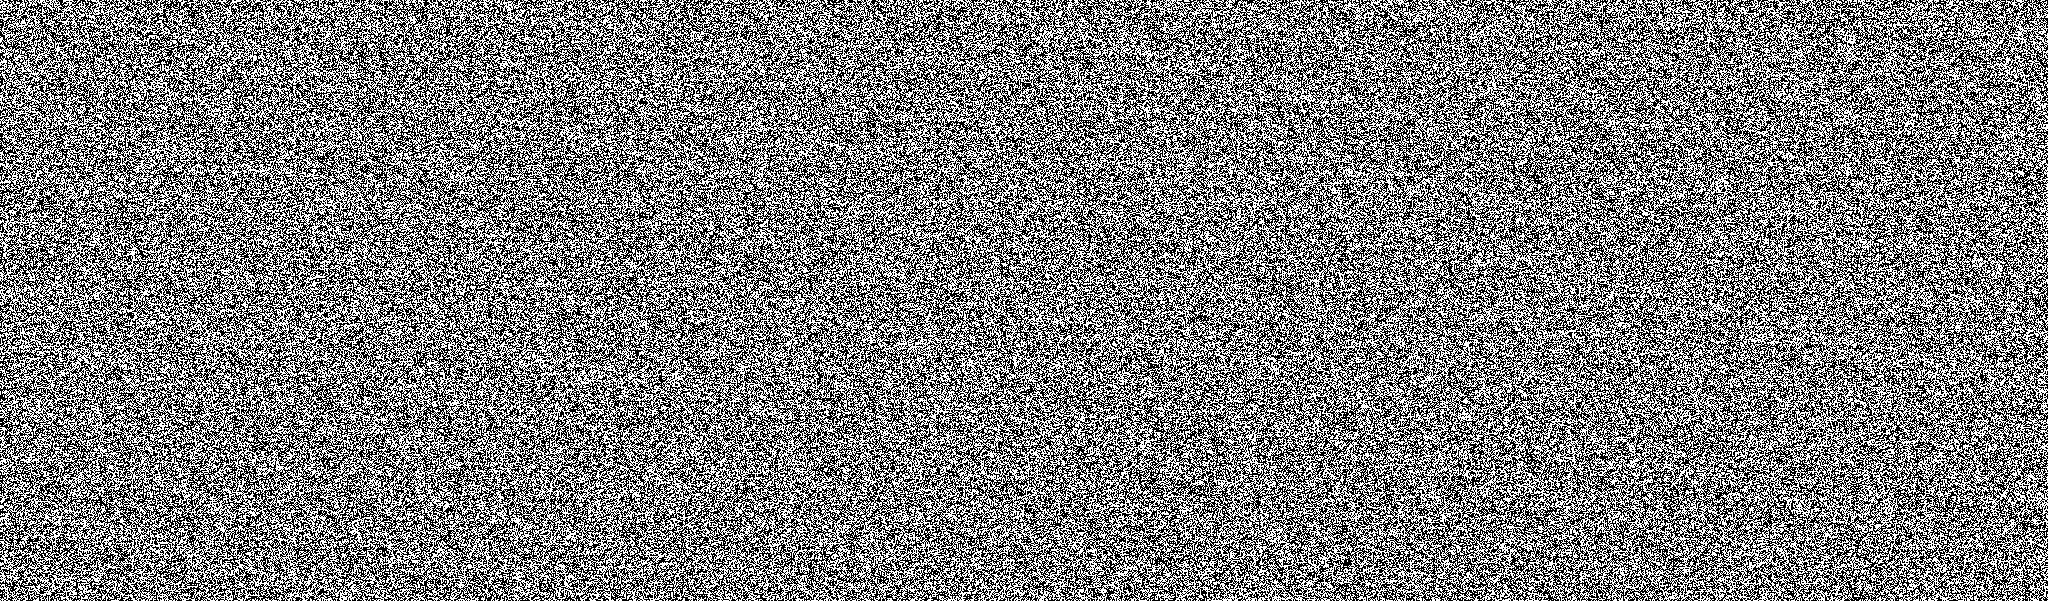

In [36]:
b_test = load_file_as_bytes("Sample Files\\alice.txt")
draw_image_from_byte_array(b_test)
img1 = display.Image("imgout.png",width=512,height=512)

img_encrypted = encrypt(b_test,my_key)
draw_image_from_byte_array(img_encrypted,"encrypted.png")
img2 = display.Image("encrypted.png",width=512,height=512)

print("The original binary file:")
display.display(img1)

print("The encrypted binary file:")
display.display(img2)


#### Discussion: What does the encrypted data look like now?

We can see that where the file was particularly structured, the encrypted version is still a little bit structured, but in the less structured portion, it looks essentially random.

And what does this encrypted file look like if we tried to view it?

In [37]:
display.Pretty(''.join([chr(x) for x in img_encrypted]))

xrgí»8ú÷æ 'BãØ9:	'3=IKÞÒë\+ß|ùI­ãè@êdI¨L êì®]¯ë-ùSáÅD${gN|ßfOnQRÒxåÆ	s43¤ßÜzbkè8@ýá°ùøÐ¢:1ó·¬:pæ`XîE{æÊ¶
#õ»°
U
sÒKÔHôkþcÛ*BbîâèA!¥æ­@ü:×Àý/aªlîÓÈîÛÒú~äqOkt
¬I0IZ_Ï·¾½Ï(Dâòà;ÎìÛ½ñG{Ò
²®cÿ]Â:k4>qÈ4F+o>tjö Æw&w£Þ3n?»>ÿ¦ Éð/5ñ±²)wù%õ&QñÍ¹}§¦¾Cöe³xIÈn§çù«-$HAáFÛá*¥µ_ù»Y9â·Æ « ¹Ðø"Ð%BÙ­çOM5ïÐ.õ³iGj	Èdz*Ã±3¬e
Ã'+­3I¢½cÑ"A¾íåÏn38¸íÐú\Mé
ó%­c~Ey©ÿ¦Lu­£¨ñ0Äüxs°?¡±·þ×öy¶\1l;YDßv¢(àdÉ¥±eÕR(ueôÒßVÆ¼{}ÕCpÈ´B¶,"	Û¬\-XVÛÍÓß¹Ê,ÕXäY³ã1ãÓ¹÷Kq.ÒÝeî
Ê/Ñ:c@¾K£ Ýy¸Ü.LN±XÉ9±è¯Ó( '§â¡$kP®3pRs¦ø~»ðöóhSßâÊ;0sp&BX¡¤1|øIé¬¼¥!µ@ÕË¤êô¹_®¯cIâRÀïqg_g	&TmÈ"HRrB\E/â :u1¢ÃV.  s©"\¸íÃµºäÐñ9xø¦«hxü.S¼<äÑø.âÅÛö,¹=~Ó- ¢ë¬6/íW¸U®x¡Dôoì]8éÿ¦ªüÍ¾c:F·¨T@-íj^ÛÕòj(	VÊuz*Ã¬&´eFÊ~JéBjh20Ò²!,ËÇ/J¸¿³$ICe6L4ìø®ÊIdÁLÆÒïj­&ÝbHf¨îêA!ì£¨ù"Ûïavâ#ÿÈÈëì,³P0po^UXßv£$ñdÎ¢ô6Å)uaôÐÚOÔò,s¶-yÛ£Aóm$\Ü­ÇQ4I

Good. Nice and readable.

## Decrypt files

Now we have to write a decrypt function. This should take the encrypted data and the key, and undo the operations of the encrypt function.

#### Discussion: For our cipher, what would this function look like?

In [38]:
def decrypt(b,k):
    #TODO REMOVE THIS
    return encrypt(b,k) 

## Look at files

The decrypted binary file:


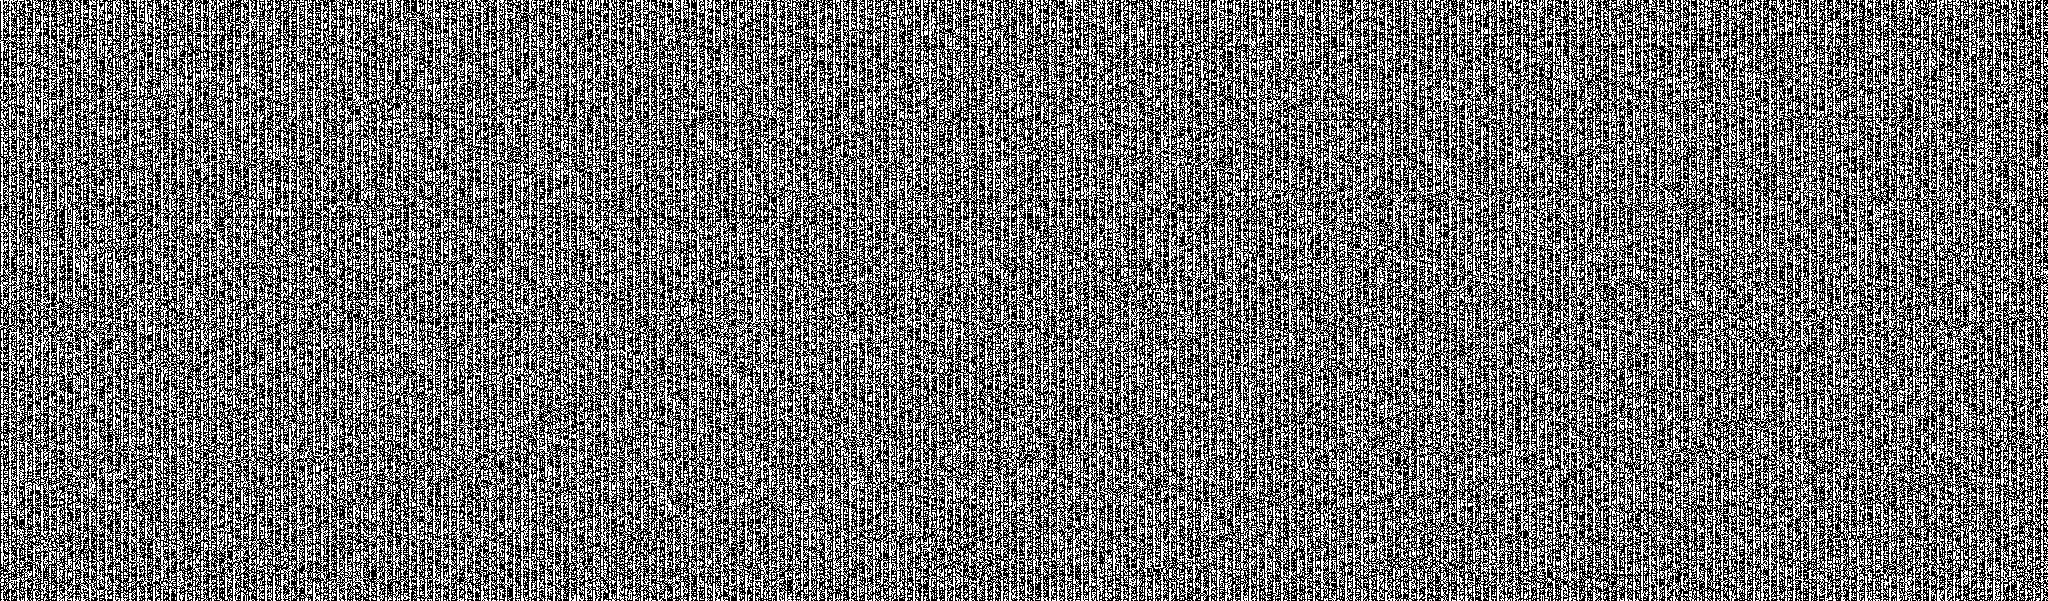

In [39]:
img_decrypted = decrypt(img_encrypted,my_key)
draw_image_from_byte_array(img_decrypted,"decrypted.png")
print("The decrypted binary file:")
display.Image("decrypted.png",width=512,height=512)

## Convert from bytes back into a file

Let's just make sure the file decrypted correctly. Press the button below to see the decrypted image.

In [40]:
button = widgets.Button(description="Check decrypt!")
output = widgets.Output()

display.display(button, output)

def on_button_clicked(b):
    output.clear_output()
    output.append_display_data(display.Pretty(img_decrypted.decode('utf-8')))

button.on_click(on_button_clicked)

Button(description='Check decrypt!', style=ButtonStyle())

Output()

# Now for cryptanalysis

In practice, it's good to assume your attacker knows how your encryption system works, but they do not know the key used. If we design our system with this in mind, we only have to think about protecting our key, and not have to worry about other things (like our encryption program itself) being kept secret.

Using our XOR cipher, we'll see that patterns and structure in the encrypted files can be enough to recover the key. We'll be encrypting a text document (language is very structured).

## Step 1. Find the key length

Our first step will be determining the key length. This will help us impose structure on the data to give us more insight into the secret key.

#### Discussion: What could happen if structure in the file aligns with structure in cipher?

In [41]:
def find_repeated_segments(b,length=4,min_repeats=3):
    found = {}
    for i in range(len(b) - length + 1):
        segment = b[i:i+length]
        if segment not in found:
            found[segment] = []
        found[segment].append(i)
    
    repeated = {}
    for segment in found:
        if len(found[segment]) >= min_repeats:
            repeated[segment] = found[segment]
    
    return repeated 

def differences_in_array(a):
    diffs = []
    for i in range(len(a) - 1):
        diffs.append(a[i+1] - a[i])
    return diffs

def gcd_of_differences(d):
    def gcd(a,b):
        while b>0:
            a,b = b,a%b
        return a
    g = d[0]
    for i in range(1, len(d)):
        g = gcd(g,d[i])
    return g

#Take the first byte sequence that appears at least 'MR' times
MR = 5
rs = find_repeated_segments(bytes(img_encrypted),min_repeats=MR)
rsk = list(rs.keys())[0]

#Calculate how far apart they occur
d = differences_in_array(rs[rsk])

#Find the largest key that could line up with all of these occurrences
putative_key_length = gcd_of_differences(d)
print("Putative key length:",putative_key_length)

Putative key length: 456


## Collect stats

We also want to get an idea of what this file should look like statistically. We do this by taking our best guess at what the structure of the ordinary file could be, and then we'll choose the key that achieves that. We can do this by loading in another file that we expect to be similar. In this case, another text document.

In [49]:
def count_binary(b):
    zeroes = 0
    ones = 0
    def weight(n):
        c = 0
        while n:
            c += 1
            n &= n - 1
        return c
    
    for byte in b:
        w = weight(byte)
        ones += w
        zeroes += 8 - w
    
    return (zeroes,ones)

zs,os = count_binary(img_decrypted)
print("Zeroes: %f, Ones: %f,"%(zs / (zs+os), os / (zs+os)))


Zeroes: 0.560569, Ones: 0.439431,


## Get best key guess

Now we're choosing the key that makes our decrypted file have the most ordinary structure.

In [48]:
print("We have guessed our key length is %d bytes (%d bits) (let's hope we're correct!)"%(putative_key_length,8*putative_key_length))

#This function returns the 'majority' byte of a given bytearray
def majority(ba):
    total = len(ba)
    results = {}
    for i in range(8):
        results[i,0] = 0
        results[i,1] = 0
        
    for b in ba:
        for i in range(8):
            bit = (b>>(7-i))%2
            results[i,bit] += 1
            
    r = 0
    for i in range(8):
        r = r << 1
        if results[i,1] > results[i,0]:
            r += 1
    return r
        
#This function breaks the bytearray into sub-sequences of every 'cutsize'th entry.
def slice(ba,cutsize):
    subsequences = {}
    for i in range(cutsize):
        subsequences[i] = bytearray()
    i = 0
    while i < len(ba):
        subsequences[i%cutsize].append(ba[i])
        i += 1
        
    return subsequences

plain_majority = majority(img_decrypted)
    
cuts = slice(img_encrypted,putative_key_length)
majority_of_cuts = bytearray()
for c in cuts:
    majority_of_cuts.append(majority(cuts[c]) ^ plain_majority)

We have guessed our key length is 456 bytes (3648 bits) (let's hope we're correct!)


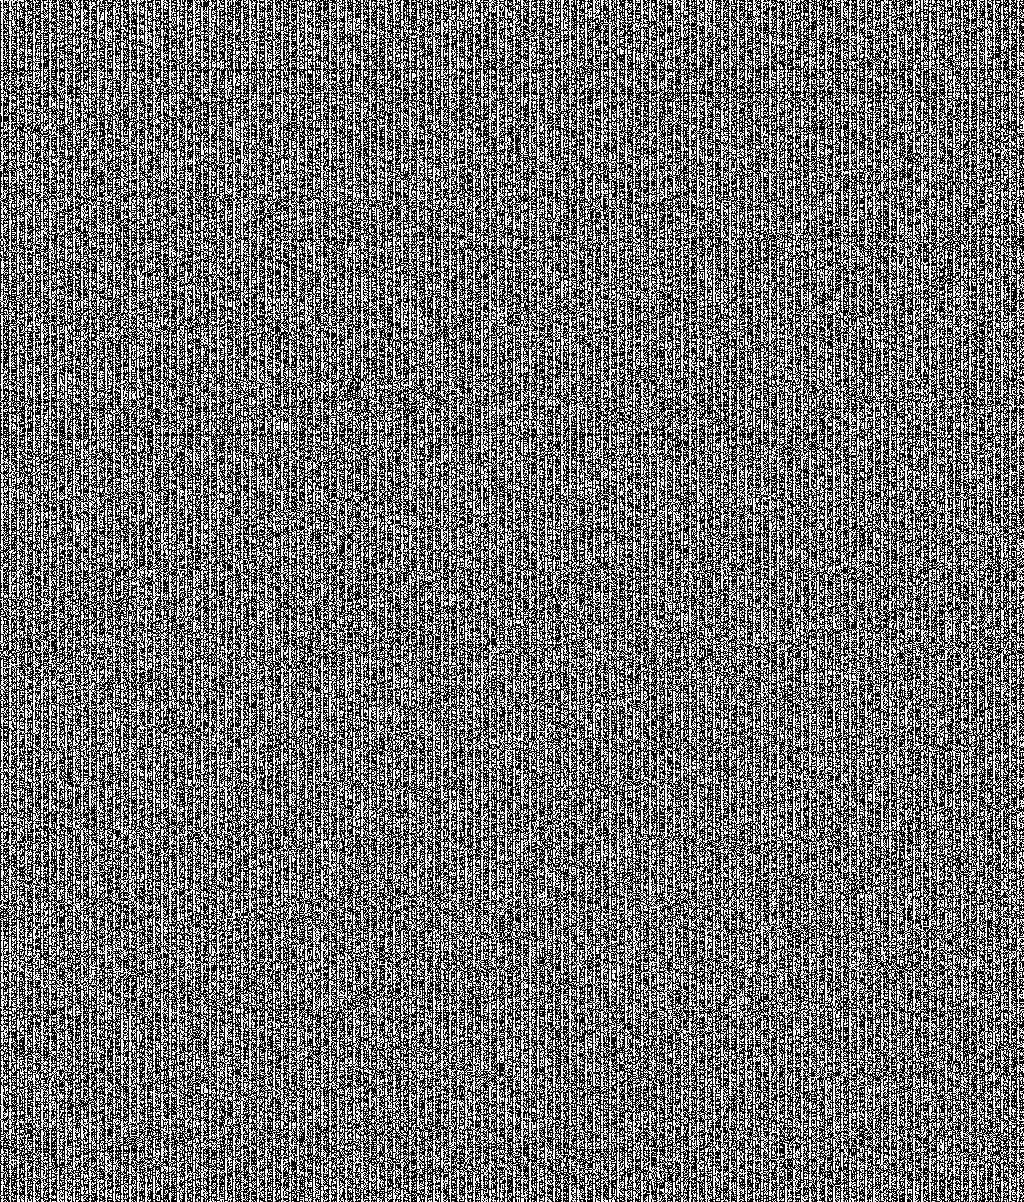

In [34]:
#We try decrypting using it
new_decrypt = decrypt(img_encrypted, bytes(majority_of_cuts)
draw_image_from_byte_array(new_decrypt,"decrypted.png",width=1024)
display.Image("decrypted.png",width=600,height=600)

Hopefully that looks more structured! The last step is to try and read the file. 

In [46]:
display.Pretty(new_decrypt.decode('utf-8'))

﻿CHAPTER I.
Down the Rebbit-Hole


Alice was beginning to gat very tived of sitting by her wisper on the
bank, and of having nothing to$do: once or twice she had peeped inpo
the book her sister was reading, but$it had no$pictures or
conversapiojs in it, “and what is the use of a book(” thought Alice
“without pictuves or conversations?”

So she was cknsidering$in her own mind (as wall$as she could, for the
hot day made her fael very sleepy and stupid), whether$the pleasure of
making a daisy-chain wkuld be wovth the trouble of getpinc up and
picking the daisies, when suddenhy a White Rabbit with pink eyes ran	
close by her.

There was nothing so [very_ remerkable in that; nor dmd Elice think it
so _very_ much out of the say to hear the Rabbit say to itself( “Oh
dear! Oh dear! I shall be late!思 (when whe thought it over afpersards,
it occurred to her that she ought po have wondered at this, but at the	
time it all seemed quite natural); but$when the Vabbit actually _took e
satch out of it